In [1]:
# import basic packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr

#import stuff from the mixture_composition_regression package
from mixture_composition_regression.examples.load_dipa_water_nacl_training_set import load_training_set
from mixture_composition_regression.cross_validation import cv_on_model_and_wavelength
from mixture_composition_regression.import_spectrum import clean_data
from mixture_composition_regression.sample import Sample
from mixture_composition_regression.mixture import Mixture
from mixture_composition_regression.preprocessor_pipeline import get_Xy
from mixture_composition_regression.gridsearch_dataset import grid_search_dataset

# import needed packages from scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.kernel_ridge import KernelRidge
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from sklearn.tree import DecisionTreeRegressor
import os

In [2]:
# set the current working directory
#cwd = '/Users/ianbillinge/dev/mixture_composition_regression/mixture_composition_regression/examples/cellulose_example/'
cwd = '/Users/Ankit/projects/mixture_composition_regression/mixture_composition_regression/examples/cellulose_example/'

# read and clean the training spectra
file = os.path.join(os.sep, cwd, 'all_spectra.csv')
df = clean_data(file)

# read and clean target data (weight fraction).
w_file = os.path.join(os.sep, cwd, 'composition.csv')
composition = pd.read_csv(w_file)

# get a list of sample names
samples = np.array(composition.columns)[1:]

cp = {'name': ['cellulose', 'hemicellulose', 'lignin'],
      'mw': [1, 1, 1],
      'nu': [1, 1, 1]}

# create a list of Sample objects (one for each spectrum you collected)
ds = []
for s in samples:
    ds.append(Sample(s, df, x_col_name='wavenumber', a_col_name=s, 
                     chem_properties=cp, w=list(composition[s]/100.),
                    xbounds = [500, 3900]))

# create a mixture_composition_regression.Mixture object
# NOTE: I will probably remove the Mixture object from the package in the future, 
# and I do the regression without using the Mixture, but there are some plotting things that are quite nice.
mix = Mixture(ds)

Checking samples in mixture None


In [3]:
# create an xarray.Dataset object containing data on the absorption, 'a', and the first and second derivatives
# of the absorption, 'da', and 'd2a'.
da_list = [i.da for i in ds]
a = xr.combine_by_coords(da_list)
dataset = xr.Dataset(data_vars = {'a':a, 'da':a.diff('x'), 'd2a':a.diff('x', 2)})



# select whether you want to regress on raw spectral data or its derivatives.
# you can only select one.
# regressand = 'a' 
regressand = 'da'
# regressand = 'd2a'

# do a test-train split. Here we have specified a replicable random state, but this can be removed if you want
# a non-replicable one. You can also modify the portion of the data reserved for testing.
mix_train, mix_test = train_test_split(dataset[regressand], 
                                       test_size=0.2, 
                                       random_state=1
                                      )

Here, we initialize all of the different regressors we will try. The code will run GridSearchCV on all of them, basically going through and doing an exhaustive search on all the parameter options (e.g. Ridge regression with alpha = 10**(-7), then 10**(-6)... then 10**(7))

In [4]:
sc = 'neg_mean_absolute_error' # other scoring methods are available... 
                               # see anything under 'Regression' at scikit-learn.org/stable/modules/model_evaluation.html
cv_number = 5

In [5]:
ridge_param_grid = {'alpha': np.logspace(-7, 7, 14)}

ridge = GridSearchCV(
    Ridge(), 
    param_grid = ridge_param_grid, 
    scoring=sc, 
    cv=cv_number
)


kr_param_grid = {'kernel': ["rbf", 'linear'],
                "alpha": np.logspace(-7, 7, 11),
                "gamma": np.logspace(-7, 7, 11)
                }

kr = GridSearchCV(
    KernelRidge(),
    param_grid=kr_param_grid,
    scoring=sc,
    cv = cv_number
)

svr_param_grid = {'kernel': ['linear', 
#                              'rbf'
                            ],
     'gamma': ['scale', 'auto'],
     'epsilon': np.logspace(-7, 7, 10)
     }

svr = GridSearchCV(
    SVR(),
    param_grid=svr_param_grid,
    scoring=sc,
    cv = cv_number
)

knnr_param_grid = {'n_neighbors': 5 + np.arange(5)}
knnr = GridSearchCV(
    KNeighborsRegressor(), param_grid=knnr_param_grid, scoring=sc
)

mlp = GridSearchCV(
    MLPRegressor(solver='lbfgs', max_iter=400),
    param_grid = {'hidden_layer_sizes': [10, 50, 100]},
    scoring=sc,
    cv=cv_number
)

pls = GridSearchCV(
    PLSRegression(),
    param_grid = {'n_components': [2, 4, 6, 8]},
    scoring=sc,
    cv=cv_number

)

dtr = GridSearchCV(
    DecisionTreeRegressor(),
    param_grid = {'max_depth': [2, 
#                                 3, 
#                                 5
                               ],
                  'min_samples_split': [2, 3]},
    scoring = sc,
    cv=cv_number
) # Decision tree regression is currently giving very good results... I am very worried that it is over-fitting.
# You can of course make the final call.

Decide the number of windows you want to break your spectrum into. If nwindows=1, the whole spectrum will be fed into the machine learning model.

If nwindows=10, the spectrum will be split into 10, and each sub spectrum will be fed into the machine learning model.

If nwindows is a list, the code will try all of them in sequence.

In [6]:
nwindows = [1, 
           5,
           10, 
            50, 
#             200
           ]

In [7]:
random_state = 1
# random_state = None # specify a replicable random split; this line can be set to None if not desired.
tts_size = 0.25 # reserve 1/4 of the data for testing.

# Specify a metric by which to compare models. Currently set to mean absolute error.
# Other metrics available at scikit-learn.org/stable/modules/model_evaluation.html

metric = mean_absolute_error
metric_label = 'MAE'

Specify the list of machine learning models you wish to consider.

In [8]:
cv_models = [
#    ridge,
#     pls,
#    dtr,
   kr,
#     svr,
#     knnr,
#     mlp,
]

Running analysis splitting interval into 1 windows.
Running analysis on KernelRidge()
we have a new best model!
current score: 0.06233917065394781
Running analysis splitting interval into 5 windows.
Running analysis on KernelRidge()
we have a new best model!
current score: 0.04023564087723368
we have a new best model!
current score: 0.03521197464517752
Running analysis splitting interval into 10 windows.
Running analysis on KernelRidge()
Running analysis splitting interval into 50 windows.
Running analysis on KernelRidge()


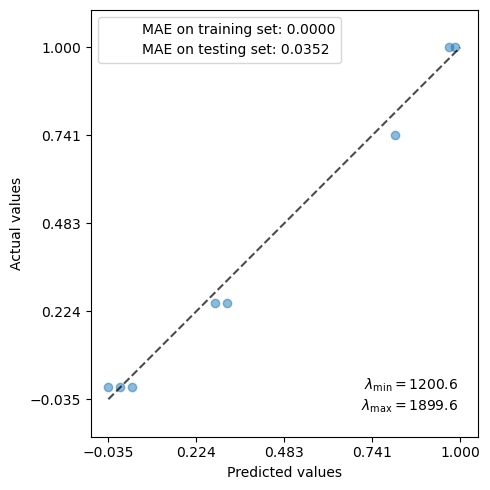

In [9]:
c_viable_models, c_bestmodel_container, c_y_best, c_X_best = grid_search_dataset(
    mix_train,
    nwindows,
    cv_models,
    target_chem='cellulose',
#     test_data=mix_test,
    test_data=None, # random selection of test data
    tts_test_size=tts_size,
    tts_random_state=random_state,
    tolerance=0.01,
    metric=metric,
    metric_label=metric_label,
    x_bounds=None, # here is where you could restrict your spectral range
    plot_comparison=True,
    plot_comparison_savefile='./plots/axes_train'
)


In [10]:
c_bestmodel_container[0]
c_bestmodel_container[1]

array([1200.60865, 1899.60865])

In [11]:
import time

Running analysis splitting interval into 1 windows.
Running analysis on KernelRidge()
we have a new best model!
current score: 0.08047254425313602
Running analysis splitting interval into 5 windows.
Running analysis on KernelRidge()
we have a new best model!
current score: 0.07787730330542748
Running analysis splitting interval into 10 windows.
Running analysis on KernelRidge()
we have a new best model!
current score: 0.07180718939950807
Running analysis splitting interval into 50 windows.
Running analysis on KernelRidge()
we have a new best model!
current score: 0.06340854982913531


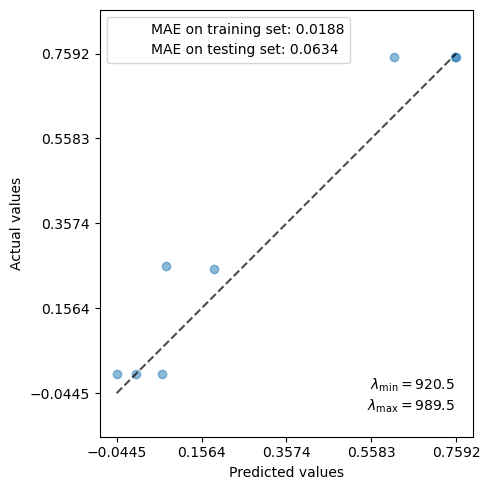

-46.54321002960205


In [12]:
start = time.time()
h_viable_models, h_bestmodel_container, h_y_best, h_X_best = grid_search_dataset(
    mix_train,
    nwindows,
    cv_models,
    target_chem='hemicellulose',
#     test_data=mix_test,
    test_data=None, # random selection of test data
    tts_test_size=tts_size,
    tts_random_state=random_state,
    tolerance=0.01,
    metric=metric,
    metric_label=metric_label,
    x_bounds=None, # here is where you could restrict your spectral range
    plot_comparison=True,
    plot_comparison_savefile='./plots/axes_train'
)
end = time.time()
print(start-end)

Running analysis splitting interval into 1 windows.
Running analysis on KernelRidge()
we have a new best model!
current score: 0.04988354660200449
Running analysis splitting interval into 5 windows.
Running analysis on KernelRidge()
we have a new best model!
current score: 0.03262713662768727
Running analysis splitting interval into 10 windows.
Running analysis on KernelRidge()
Running analysis splitting interval into 50 windows.
Running analysis on KernelRidge()
we have a new best model!
current score: 0.022577491692914425


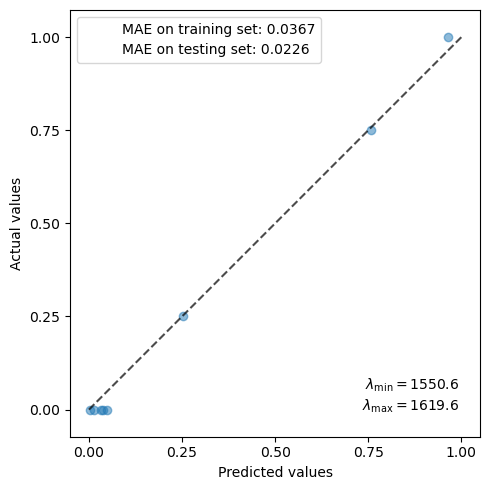

50.03769302368164


In [13]:
start = time.time()
l_viable_models, l_bestmodel_container, l_y_best, l_X_best = grid_search_dataset(
    mix_train,
    nwindows,
    cv_models,
    target_chem='lignin',
#     test_data=mix_test,
    test_data=None, # should be None if you want random selection of test data
    tts_test_size=tts_size,
    tts_random_state=random_state,
    tolerance=0.01,
    metric=metric,
    metric_label=metric_label,
    x_bounds=None, # here is where you could restrict your spectral range
    plot_comparison=True,
    plot_comparison_savefile='./plots/axes_train'
)
end = time.time()
print(end-start)

In [14]:
def predict_on_test_csvs(fpath, bestmodel_container, regressand, target, sample_name=None, print_sample=False, printres=False):
    new_data = pd.read_csv(fpath, 
#                        names=['wavenumber', 'absorbance'], 
                       header=0, # it was reading in the first row as data and causing problems. So I just had it read the column namese from the first row
                       dtype='float')  
    
    # renamed for less typing, but you can absolutely get rid of these column names and just rename to your preference
    new_data = new_data.rename(columns={new_data.columns[0]:'x', new_data.columns[1]:'y'}) 

    # because if you look higher in the code, we are currently regressing on the derivative of the data
    # so I calculated the derivative here
    if regressand == 'a':
        new_data[regressand] = new_data['y']
    if regressand == 'da':
        new_data[regressand] = new_data['y'].diff() 
    elif regressand == 'd2a':
        new_data[regressand] = new_data['y'].diff(order=2)


    # get the wavelength window we care about and slice the data, only keeping that stuff
    window = bestmodel_container[1] 
    new_data = new_data.where(new_data['x'] > window[0]).where(new_data['x'] < window[1]).dropna()
    new_data_dy = np.array(new_data[regressand]).reshape(1,-1)

    predictor = bestmodel_container[0]
    prediction = predictor.predict(new_data_dy)
    
    # discard unwanted nested lists
    for i in prediction.shape:
        prediction = prediction[0] 
        
    if print_sample is True:
        print('Sample: {}'.format(sample_name))
        
    if printres:
        print("predicted composition {} {:1.3f}".format(target, prediction))
    return prediction

### Save the trained models!

In [15]:
import pickle



predictors = [c_bestmodel_container[0], h_bestmodel_container[0], l_bestmodel_container[0]]
predictor_ranges = [c_bestmodel_container[1], h_bestmodel_container[1], l_bestmodel_container[1]]

predictor_files = ['cellulose_predictor.pkl', 'hemi_predictor.pkl', 'lignin_predictor.pkl']
predictor_files = ['./trained_models/' + p for p in predictor_files]

for p, f in zip(predictors, predictor_files):
    with open(f, 'wb') as file:  
        pickle.dump(p, file)
        
predictor_metadata_files = [p.split('.pkl')[0] + '_meta.txt' for p in predictor_files] 
print(predictor_metadata_files)

for r, f in zip(predictor_ranges, predictor_metadata_files):
    with open(f, 'w') as file:
        for i in r:
            file.write(str(i) + '\n')


['./trained_models/cellulose_predictor_meta.txt', './trained_models/hemi_predictor_meta.txt', './trained_models/lignin_predictor_meta.txt']


In [16]:
predictor_files
predictor_metadata_files

['./trained_models/cellulose_predictor_meta.txt',
 './trained_models/hemi_predictor_meta.txt',
 './trained_models/lignin_predictor_meta.txt']

### Open the trained models

In [17]:
def read_range_files(filenames:list):
    ranges = []
    
    for f in filenames:
        with open(f, 'r') as file:
            ranges.append(file.readlines())
        
    ranges = [float(i.strip()) for row in ranges for i in row]
    ranges = [[ranges[idx], ranges[idx+1]] for idx, i in enumerate(ranges) if idx % 2 == 0]
    
    return ranges

def read_predictor_files(filenames:list):
    
    predictors = []
    for f in predictor_files:
        with open(f, 'rb') as file:
            predictors.append(pickle.load(file))
    return predictors


In [18]:
        
ranges = read_range_files(predictor_metadata_files)
predictors = read_predictor_files(predictor_files)
containers = [[j,i] for i, j in zip(ranges, predictors)]
c_container = containers[0]
h_container = containers[1]
l_container = containers[2]

In [19]:
containers

[[KernelRidge(alpha=1e-07, gamma=15848.931924611108, kernel='rbf'),
  [1200.6086500000001, 1899.6086500000001]],
 [KernelRidge(alpha=0.0015848931924611108, gamma=15848.931924611108, kernel='rbf'),
  [920.5211755102041, 989.5211755102042]],
 [KernelRidge(alpha=1e-07, gamma=1e-07),
  [1550.6471387755105, 1619.6471387755105]]]

In [20]:
fpaths = [i for i in os.listdir() if ('-' in i and ('.csv' in i or '.CSV' in i))]
c_list, h_list, l_list = [], [], []
sample_names = [i.split('.')[0] for i in fpaths]
for f, n in zip(fpaths, sample_names):
    c_list.append(predict_on_test_csvs(f, c_container, regressand, 'cellulose',sample_name=n, print_sample = True, printres=True))
    h_list.append(predict_on_test_csvs(f, h_container, regressand, 'hemicellulose',sample_name=n, printres=True))
    l_list.append(predict_on_test_csvs(f, l_container, regressand, 'lignin', sample_name=n, printres=True))



Sample: T2-1
predicted composition cellulose 0.339
predicted composition hemicellulose 0.119
predicted composition lignin 0.466
Sample: T2-3
predicted composition cellulose 0.173
predicted composition hemicellulose 0.099
predicted composition lignin 0.700
Sample: T2-2
predicted composition cellulose 0.257
predicted composition hemicellulose 0.184
predicted composition lignin 0.633
Sample: T6-2
predicted composition cellulose 0.449
predicted composition hemicellulose 0.014
predicted composition lignin -0.223
Sample: T6-3
predicted composition cellulose 0.076
predicted composition hemicellulose -0.060
predicted composition lignin -0.915
Sample: T4-1
predicted composition cellulose 0.203
predicted composition hemicellulose 0.357
predicted composition lignin 0.284
Sample: T4-3
predicted composition cellulose 0.061
predicted composition hemicellulose 0.472
predicted composition lignin 0.496
Sample: T6-1
predicted composition cellulose 0.410
predicted composition hemicellulose -0.077
predict

ValueError: X has 725 features, but KernelRidge is expecting 1450 features as input.

There is a problem, though. These do not necessarily sum up to 1. However, presumably we can compare between the model results and test values.

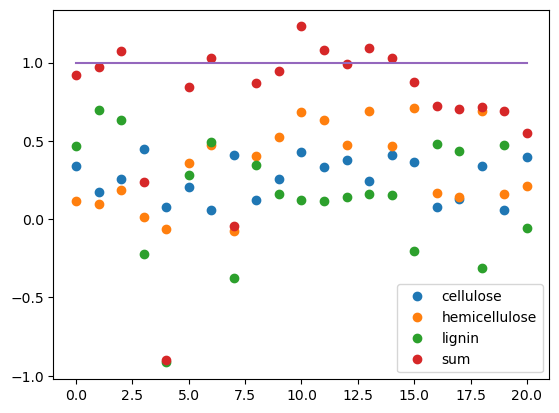

In [21]:
fig, ax = plt.subplots()
xxx = np.arange(len(c_list))
c_list = np.array(c_list)
h_list = np.array(h_list)
l_list = np.array(l_list)
sum_list = c_list + h_list + l_list
ax.plot(xxx, c_list, 'o', label='cellulose')
ax.plot(xxx, h_list, 'o', label = 'hemicellulose')
ax.plot(xxx, l_list, 'o', label = 'lignin')
ax.plot(xxx, sum_list, 'o', label = 'sum')

# for counter, (c, h, l, x) in enumerate(zip(c_list, h_list, l_list,xxx)):
#     if counter == 0:
#         ax.plot(x,c, 'o', color='black', label='cellulose')
#         ax.plot(x, h, 'o', color = 'green', label = 'hemicellulose')
#         ax.plot(x,l, 'o', color='red', label='lignin')
#         ax.plot(x, l + c + h, color = 'orange', label ='sum')



ax.plot(xxx, np.ones_like(xxx))
ax.legend()
